# Visualize track result

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import json

def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()


#### Load track data

In [10]:
dataset = 'simulation_data'
scenario = '1-1'
#datafolder = 'simulation_20250305_160930' # set the folder name
datafolder = 'simulation_20250307_124152' # set the folder name
#datafolder = 'simulation_20250304_143046' # set the folder name
nsample = 100 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
obstacles = json.load(open(f"./data/{dataset}/Scenario{scenario}/obstacles.json"))
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)


# samples: original predictions

all_target_np = all_target.cpu().numpy() # observed value (ground truth)
all_evalpoint_np = all_evalpoint.cpu().numpy() # target mask
all_observed_np = all_observed.cpu().numpy() # observed mask
all_given_np = all_observed_np - all_evalpoint_np # the mask for the given data (used for imputation)

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

In [33]:
gt_data = all_target_np
#imputed_data = quantiles_imp[2] # 0.5 quantile(median of samples)
imputed_data = samples.cpu().numpy()[:,10]
prediction_mask = all_observed_np[:,:,0] # observed mask
given_mask = all_given_np[:,:,0] # given mask

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_track(gt_data, imputed_data, prediction_mask, given_mask, track_idx, color, legend_entries):
    """
    Plots a single track with ground truth, observed points, and imputed predictions.
    """
    given_mask_track = given_mask[track_idx]
    prediction_mask_track = prediction_mask[track_idx]

    # Extract x and y coordinates
    x_gt = gt_data[track_idx, :, 0]  
    y_gt = gt_data[track_idx, :, 1]  
    x_obs = x_gt[given_mask_track == 1]  
    y_obs = y_gt[given_mask_track == 1]  
    x_pred = imputed_data[track_idx, :, 0]  
    y_pred = imputed_data[track_idx, :, 1]  

    # Only keep observed points
    x_gt = x_gt[prediction_mask_track == 1]
    y_gt = y_gt[prediction_mask_track == 1]
    x_pred = x_pred[prediction_mask_track == 1]
    y_pred = y_pred[prediction_mask_track == 1]

    # Plot predicted track
    plt.plot(x_pred, y_pred, color=color, linestyle='solid', label=f'Track {track_idx} (Predicted)')

    # Plot ground truth and observed points
    plt.scatter(x_gt, y_gt, color=color, marker='o', alpha=0.6, label=None)  

    # Handle observed points:
    if len(x_obs) == 1:
        plt.scatter(x_obs, y_obs, color='yellow', marker='x', label="Observed Point (First & Last)")
    elif len(x_obs) >= 2:
        plt.scatter(x_obs[0], y_obs[0], color='yellow', marker='x', label="Observed Point (start)" if "first" not in legend_entries else None)  # First point 🟡
        plt.scatter(x_obs[1:-1], y_obs[1:-1], color='green', marker='x', label="Observed Points (Middle)" if "middle" not in legend_entries else None)  # Middle points 🟢
        plt.scatter(x_obs[-1], y_obs[-1], color='red', marker='x', label="Observed Point (End)" if "last" not in legend_entries else None)  # Last point 🔴
        legend_entries.update(["first", "middle", "last"])


def draw_obstacles(obstacles, legend_entries):
    """
    Draws all obstacles, ensuring unique legend entries.
    """
    if not obstacles:
        return

    for obstacle in obstacles:
        if "rectangle" in obstacle:
            rect = obstacle["rectangle"]
            x1, y1 = rect["p1"]
            x2, y2 = rect["p2"]
            label = "Obstacle (Rectangle)" if "rectangle" not in legend_entries else None
            plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='gray', alpha=0.5, label=label)
            legend_entries.add("rectangle")

        elif "standing_person" in obstacle:
            x, y = obstacle["standing_person"]
            label = "Standing Person" if "standing_person" not in legend_entries else None
            plt.scatter(x, y, color='black', marker='*', s=200, label=label)
            legend_entries.add("standing_person")

        elif "circle" in obstacle:
            circle_info = obstacle["circle"]
            center = circle_info["center"]
            radius = circle_info["radius"]
            label = "Obstacle (Circle)" if "circle" not in legend_entries else None
            circle = plt.Circle(center, radius, color='gray', alpha=0.5, label=label)
            plt.gca().add_patch(circle)
            legend_entries.add("circle")

        elif "wall" in obstacle:
            wall_points = obstacle["wall"]
            x_vals, y_vals = zip(*wall_points)
            label = "Wall" if "wall" not in legend_entries else None
            plt.plot(x_vals, y_vals, color='black', linestyle='-', linewidth=1, label=label)
            legend_entries.add("wall")

        elif "entrance" in obstacle:
            entrance = obstacle["entrance"]
            x1, y1 = entrance["p1"]
            x2, y2 = entrance["p2"]
            label = "Entrance" if "entrance" not in legend_entries else None
            plt.plot([x1, x2], [y1, y2], color='blue', linestyle='-', linewidth=5, label=label)
            legend_entries.add("entrance")


def visualize_all_tracks(gt_data, imputed_data, prediction_mask, given_mask, obstacles=None):
    """
    Plots all tracks along with obstacles.
    """
    plt.figure(figsize=(12, 8))
    plt.rcParams["font.size"] = 16

    num_tracks = gt_data.shape[0]  # Number of tracks
    #colors = plt.cm.get_cmap("tab10", num_tracks)  # Assign unique colors to each track
    colors = plt.get_cmap("tab10")  # Assign unique colors to each track
    legend_entries = set()  # Keep track of legend entries to avoid duplicates

    for track_idx in range(num_tracks):
        plot_track(gt_data, imputed_data, prediction_mask, given_mask, track_idx, colors(track_idx), legend_entries)

    draw_obstacles(obstacles, legend_entries)

    # Set the axis limits
    plt.xlim(0, 84)  
    plt.ylim(6, 18)  

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Multiple Tracks Visualization with Obstacles")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.grid()
    plt.show()


def visualize_single_track(gt_data, imputed_data, prediction_mask, given_mask, track_idx, obstacles=None):
    """
    Plots a single track with obstacles.
    """
    plt.figure(figsize=(12, 8))
    plt.rcParams["font.size"] = 16

    #colors = plt.cm.get_cmap("tab10", 1)  # Single color for one track
    colors = plt.get_cmap("tab10")  # Assign unique colors to each track
    legend_entries = set()  # Keep track of legend entries

    plot_track(gt_data, imputed_data, prediction_mask, given_mask, track_idx, colors(0), legend_entries)
    draw_obstacles(obstacles, legend_entries)

    # Set the axis limits
    plt.xlim(0, 84)  
    plt.ylim(6, 18)  

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"Track {track_idx} Visualization with Obstacles")
    plt.legend()
    plt.grid()
    plt.show()

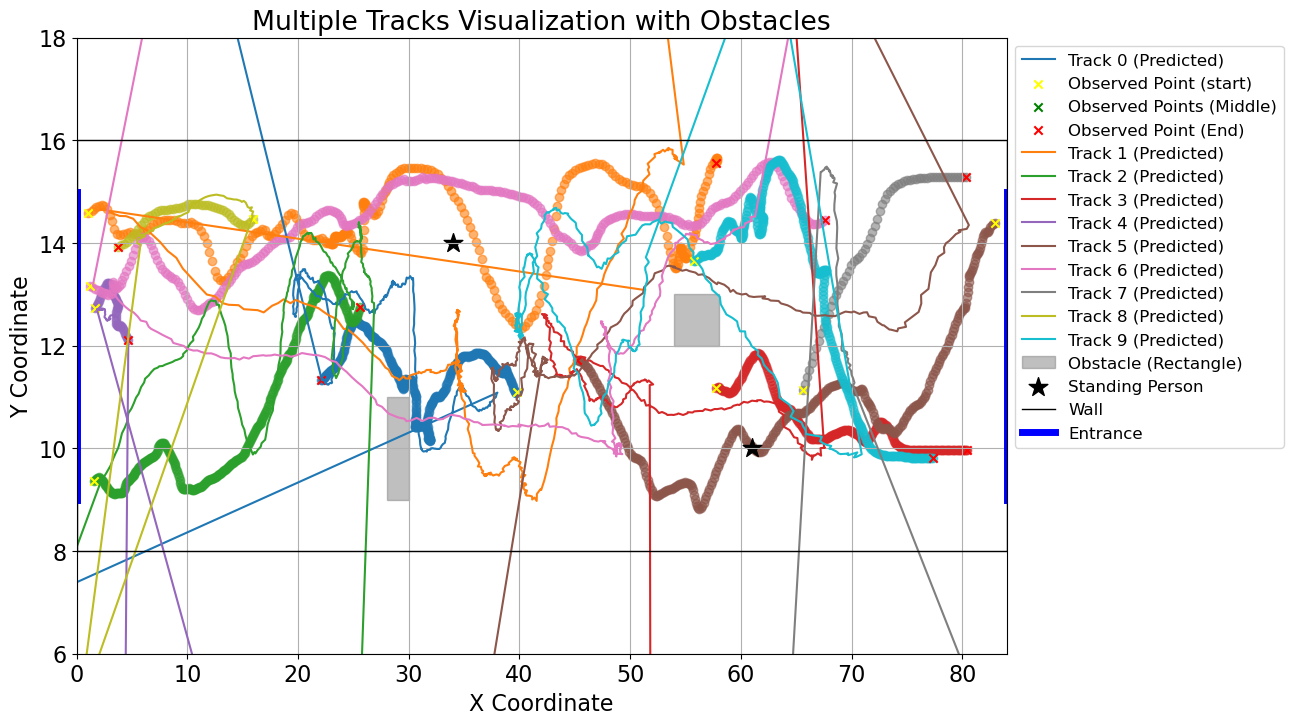

In [34]:
start_ind = 45
end_ind = 55
visualize_all_tracks(gt_data[start_ind:end_ind], imputed_data[start_ind:end_ind], prediction_mask[start_ind:end_ind], given_mask[start_ind:end_ind], obstacles)

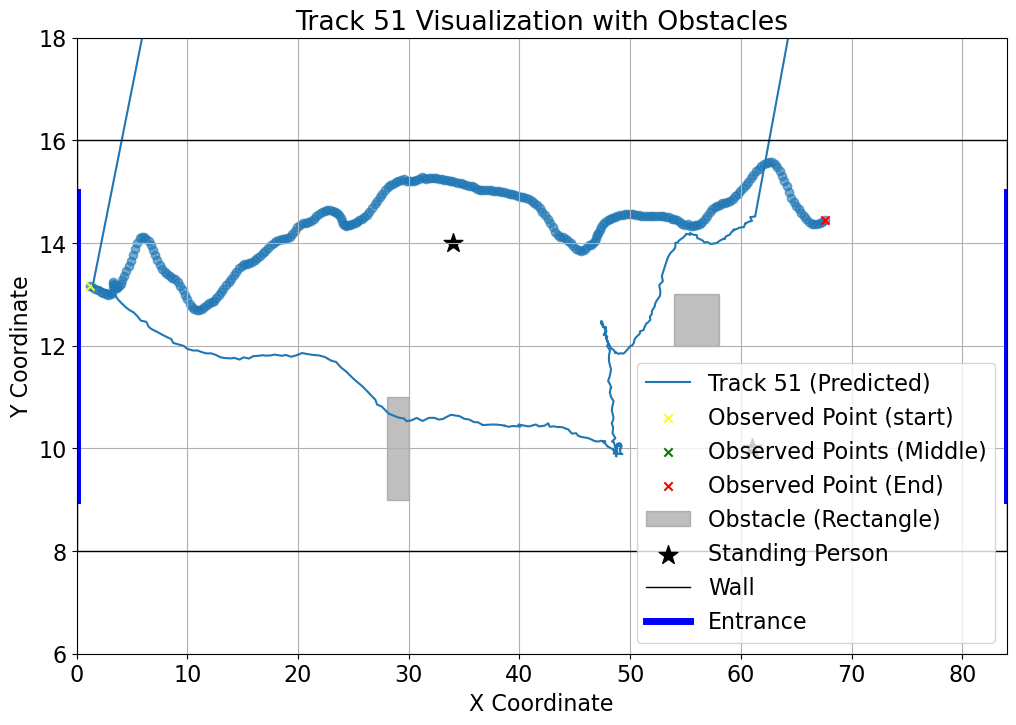

In [35]:
track_idx = 51
visualize_single_track(gt_data, imputed_data, prediction_mask, given_mask, track_idx, obstacles)